# 三点測量による三次元測位


- 位相とRSSIを併用した測距手法で３つのアンテナから測定した距離を用いた三点測量により、タグの位置を三次元プロットする。
- 三点測量法は、アンテナからタグまでの距離を半径とした３つの球の交点を測定位置とする。

1. パッケージのimport

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from numpy.random import default_rng
from lmfit.models import SineModel
from scipy.optimize import curve_fit
%matplotlib inline

2. 各定数の設定

In [92]:
c = 2.998e8 #光の速度
f = 920.4e6 #周波数
wavelength = c / f * 100 #理論波長
RSSI0 = -58.5 #単位RSSI

3. 使用するタグの一覧

In [93]:
TagTable1 = {
    'Tag1' : '9990 1912 9990 9990 9990 0097',
    'Tag2' : '9990 1912 9990 9990 9990 0098',
    'Tag3' : '9990 1912 9990 9990 9990 0099',
    'Tag4' : '9990 1912 9990 9990 9990 0100',
    'Tag5' : '9990 1912 9990 9990 9990 0101',
    'Tag6' : '9990 1912 9990 9990 9990 0102',
    'Tag7' : '9990 1912 9990 9990 9990 0103',
    'Tag8' : '9990 1912 9990 9990 9990 0104',
    'Tag9' : '9990 1912 9990 9990 9990 0105',
    'Tag10' : '9990 1912 9990 9990 9990 0106',
}

In [94]:
class RfidDf:
    def __init__(self, csv_file:str, tag_table:dict):
        self.df=pd.read_csv(csv_file)
        self.data_size = len(self.df)
        self.tag_table = tag_table

    def culDistance(self, value:float):
        return pow(10, (RSSI0 - value)/20) * 100

    def tagTableInverseLookup(self, x:str):
        for k,v in self.tag_table.items():
            if x == v:
                return k                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

    def addDistance(self):
        columns = ['Tag No.', 'RSSI', 'Distance', 'Phase']
        data = np.empty((0,4))
        for i in range(0, len(self.df)-1):
            if self.df['Tag ID'][i] in self.tag_table.values():
                data=np.append(
                    data,
                    [[self.tagTableInverseLookup(self.df['Tag ID'][i]), self.df['RSSI'][i], float(self.culDistance(self.df['RSSI'][i])), self.df['Phase'][i]]],
                    axis=0
                )
        df2 = pd.DataFrame(
            columns=columns,
            data = data
        )
        return df2

    def getMean(self):
        columns = ['Tag No.', 'Block Base', 'RSSI', 'Phase']
        data = np.empty((0,4))
        for i in range(1, len(self.tag_table)+1):
                rfiddf = self.df[self.df['Tag ID'] == self.tag_table[f'Tag{i}']]
                data = np.append(
                    data,
                    [[f'Tag {i}', 16.28 * (i-1), rfiddf['RSSI'].mean(), rfiddf['Phase'].mean()]],
                    axis=0
                )
        rfiddf2 = pd.DataFrame(
            columns=columns,
            data=data
        )
        return rfiddf2

    def getTagInfoList(self, info_type:str):
        return [[float(item) for item in self.addDistance()[self.addDistance()['Tag No.'] == f'Tag{i}'][info_type].tolist()] for i in range(1, len(self.tag_table)+1)]

In [95]:
rfiddf = RfidDf(csv_file='results2.csv', tag_table=TagTable1)
rfiddf.getMean().head()

,Tag No.,Block Base,RSSI,Phase
0,Tag 1,0.0,-42.8921568627451,0.6898702617832364
1,Tag 2,16.28,-42.765306122448976,5.940575394064883
2,Tag 3,32.56,-47.46938775510204,1.023947828778848
3,Tag 4,48.84,-49.795918367346935,6.1367997119927855
4,Tag 5,65.12,-56.45652173913044,2.0790775261199603


In [96]:
rfiddf.addDistance().head()

,Tag No.,RSSI,Distance,Phase
0,Tag4,-64.0,188.36490894898006,5.71868037723767
1,Tag2,-55.0,66.83439175686146,2.5157284921324514
2,Tag6,-60.5,125.89254117941672,4.086524818927348
3,Tag1,-50.5,39.81071705534972,3.2459033471660166
4,Tag5,-61.0,133.3521432163324,0.7915340865489908


In [97]:
class RfidDfPlotter:
    def __init__(self, rfid_df:RfidDf):
        self.rfid_df = rfid_df
        self.infoTypeYticks = {
            'RSSI' : np.arange(-65, -39, 5),
            'Distance' : np.arange(0, 170, 16.8),
            'Phase' : np.arange(-6.5, 6.5, 0.5)
        }
        
    def rfiddfBoxplot(self, data_type:str):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.boxplot(self.rfid_df.getTagInfoList(data_type))
        ax.set_xticklabels(list(rfiddf.tag_table.keys()))
        ax.set_yticks(self.infoTypeYticks[data_type])


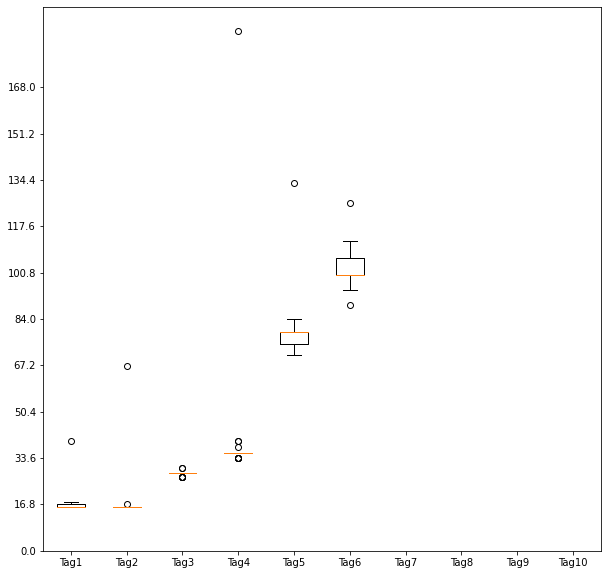

In [98]:
rfidPlotter = RfidDfPlotter(rfiddf)
rfidPlotter.rfiddfBoxplot('Distance')